In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [9]:
# X = pd.read_csv('test_data.csv', index_col=0)
data_path = './data/'
data = []
for data_file in os.listdir(data_path):
    data_file_path = os.path.join(data_path, data_file)
    X = pd.read_csv(data_file_path, index_col=0)
    X['type'] = (X['type']!='0').astype(int)
    data.append(X)

In [29]:
def concatenate_XY(Xs, Ys):
    features = Xs[0].columns
    X = pd.DataFrame(columns=features)
    Y = pd.Series(name='type')
    for X_, Y_ in zip(Xs, Ys):
        X = pd.concat([X, X_], axis=0, ignore_index=True)
        Y = Y.append(Y_, ignore_index=True)
    return X, Y

In [30]:
def split_train_test(data, test_size=0.3, mix_all=True):
    Ys = [X['type'] for X in data]
    Xs = [X.drop('type', axis=1) for X in data]
    if mix_all:
        X, Y = concatenate_XY(Xs, Ys)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    else:
        # keep complete graph for test
        num_test_graph = max(1, int(len(data)*test_size))
        test_indice = np.random.choice(range(len(data)), size=num_test_graph, replace=False)
        Xs_train = [X for i, X in enumerate(Xs) if i not in test_indice]
        Ys_train = [Y for i, Y in enumerate(Ys) if i not in test_indice]
        X_train, Y_train = concatenate_XY(Xs_train, Ys_train)
        X_test = [X for i, X in enumerate(Xs) if i in test_indice]
        Y_test = [Y for i, Y in enumerate(Ys) if i in test_indice]
    return X_train, X_test, Y_train, Y_test

In [31]:
X_train, X_test, Y_train, Y_test = split_train_test(data)

In [80]:
def feature_sum(X, normalize=False):
    if normalize:
        X_ = X.copy()
        X_min = X_.min(axis=0)
        X_max = X_.max(axis=0)
        X_scale = X_max - X_min
        X_ = (X_ - X_min) / X_scale
        return X_.sum(axis=1)
    return X.sum(axis=1)

In [43]:
pred_fs = feature_sum(X_train, normalize=True)

In [59]:
from utils import precision_recall, average_precision

In [48]:
sample_sizes = [8, 16, 32, 64, 128, 256, 512, 800]
results = precision_recall(pred_fs, Y, *sample_sizes)

In [51]:
list(zip(sample_sizes, results))

[(8, (1.0, 0.04419889502762431)),
 (16, (1.0, 0.08839779005524862)),
 (32, (1.0, 0.17679558011049723)),
 (64, (0.78125, 0.27624309392265195)),
 (128, (0.46875, 0.3314917127071823)),
 (256, (0.265625, 0.3756906077348066)),
 (512, (0.236328125, 0.6685082872928176)),
 (800, (0.19875, 0.8784530386740331))]

In [50]:
avg_prec = average_precision(pred_fs, Y)
avg_prec

0.4491163368239156

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfs = []
for n_estimators in [10, 20, 50, 100]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=5, max_features='auto', n_jobs=-1)
    rf

In [36]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5, max_features='auto', n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
feature_rank = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1], reverse=True)
feature_rank

[('second_density', 0.09852105708875605),
 ('NetEMD_lower_1', 0.08927607019128674),
 ('degree_std', 0.08003564140987088),
 ('gaw20_score', 0.06233316142377585),
 ('NetEMD_lower_2', 0.061509809070066965),
 ('path_2', 0.04945105083185256),
 ('first_strength', 0.048770211068831656),
 ('gaw_score', 0.04378491154489465),
 ('third_density', 0.04056664205553584),
 ('second_strength', 0.03574373446254246),
 ('path_18', 0.028119539274564814),
 ('comb_ipr_4', 0.02228738917181209),
 ('path_16', 0.01945683070224047),
 ('lower_ipr_4', 0.018166094808872227),
 ('lower_absolute_value', 0.015811781103968286),
 ('comb_absolute_value', 0.014970658036673246),
 ('upper_exp_2', 0.01470680765437378),
 ('lower_exp_2', 0.01456383692044246),
 ('NetEMD_rw_1', 0.014511786723428139),
 ('path_20', 0.014415835719781283),
 ('rw_ipr_4', 0.01358794590216946),
 ('path_13', 0.012923712433149295),
 ('gaw10_score', 0.012460986346166094),
 ('first_density', 0.010970249731904975),
 ('NetEMD_rw_2', 0.010457054010781662),
 ('p

In [45]:
f_rank = np.array([x[1] for x in feature_rank])
f_rank = np.cumsum(f_rank)
f_rank

array([0.09852106, 0.18779713, 0.26783277, 0.33016593, 0.39167574,
       0.44112679, 0.489897  , 0.53368191, 0.57424855, 0.60999229,
       0.63811183, 0.66039922, 0.67985605, 0.69802214, 0.71383392,
       0.72880458, 0.74351139, 0.75807523, 0.77258701, 0.78700285,
       0.8005908 , 0.81351451, 0.82597549, 0.83694574, 0.8474028 ,
       0.85704428, 0.86664143, 0.87589392, 0.88475851, 0.89301359,
       0.90098587, 0.90866353, 0.91561237, 0.92233221, 0.92809733,
       0.93348315, 0.93825932, 0.94243647, 0.94619189, 0.94991404,
       0.95346749, 0.9567903 , 0.96006158, 0.96327453, 0.96632109,
       0.96899316, 0.97164825, 0.97390492, 0.97595742, 0.97796426,
       0.97990944, 0.98185304, 0.98356919, 0.98500127, 0.98633494,
       0.98751132, 0.98868056, 0.98982212, 0.99093196, 0.99202879,
       0.99292837, 0.99381841, 0.9946021 , 0.99533824, 0.9960591 ,
       0.99676688, 0.99738056, 0.997931  , 0.99847548, 0.99899863,
       0.99939807, 0.99971919, 0.99985206, 0.99996548, 1.     

In [46]:
import matplotlib.pyplot as plt

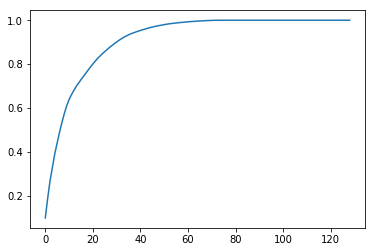

In [47]:
plt.plot(f_rank)

In [56]:
pred_rf = rf.predict_proba(X_test)[:, 1]

In [60]:
sample_sizes = [8, 16, 32, 64, 128, 256, 512, 800]
results = precision_recall(pred_rf, Y_test, *sample_sizes)

In [61]:
list(zip(sample_sizes, results))

[(8, (1.0, 0.1038961038961039)),
 (16, (1.0, 0.2077922077922078)),
 (32, (1.0, 0.4155844155844156)),
 (64, (0.796875, 0.6623376623376623)),
 (128, (0.4375, 0.7272727272727273)),
 (256, (0.25390625, 0.8441558441558441)),
 (512, (0.150390625, 1.0)),
 (800, (0.09625, 1.0))]

In [63]:
avg_prec = average_precision(pred_rf, Y_test)
avg_prec

0.7478990447040772